In [ ]:
from itertools import product

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm

from numpy.random import default_rng

In [ ]:
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

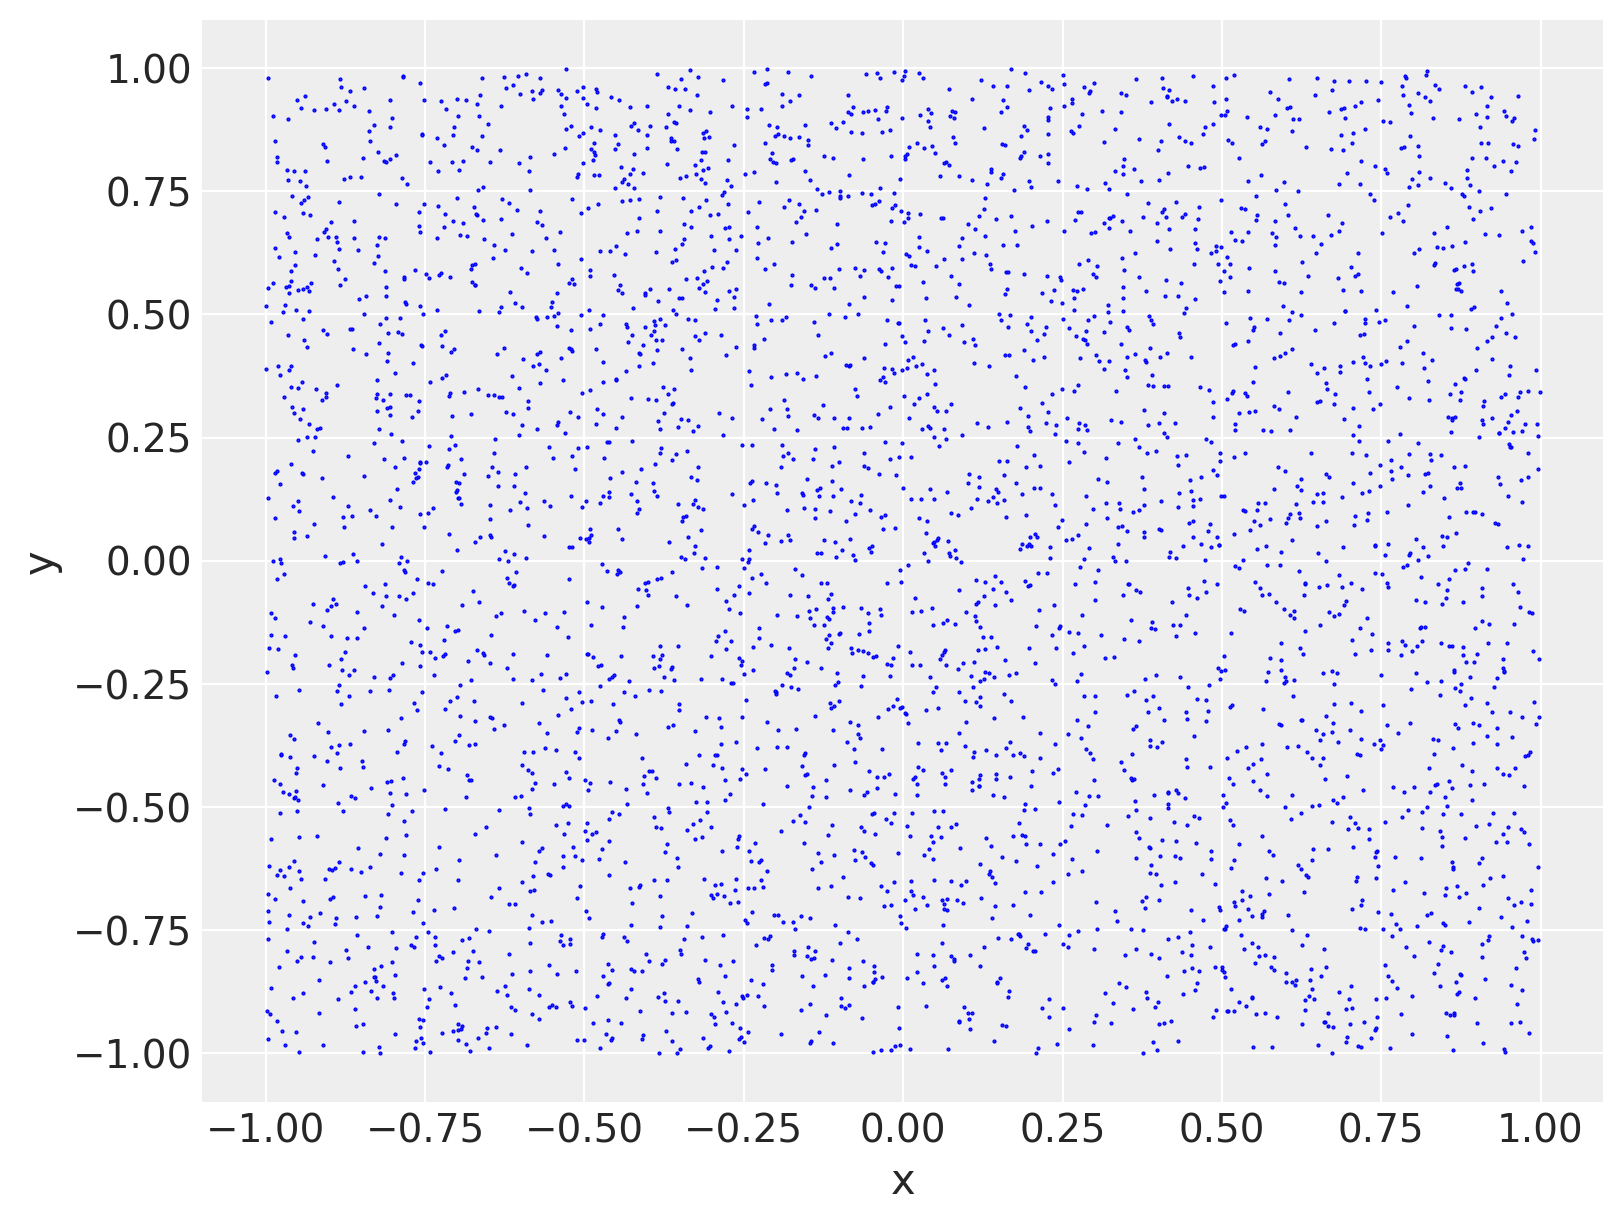

In [ ]:
import numpy as np; #NumPy package for arrays, random number generation, etc
import matplotlib.pyplot as plt #For plotting
from scipy.optimize import minimize #For optimizing
from scipy import integrate

#np.random.seed(0)
plt.rcParams["figure.figsize"] = (8,6)
 
#Simulation window parameters
xMin=-1;xMax=1;
yMin=-1;yMax=1;
xDelta=xMax-xMin;yDelta=yMax-yMin; #rectangle dimensions
areaTotal=xDelta*yDelta;
 
s=5; #scale parameter
 
#Point process parameters
def fun_lambda(x,y):
    return 1000*np.exp(-(x**2+y**2)/s**2); #intensity function
 
###START -- find maximum lambda -- START ###
#For an intensity function lambda, given by function fun_lambda,
#finds the maximum of lambda in a rectangular region given by
#[xMin,xMax,yMin,yMax].
def fun_Neg(x):
    return -fun_lambda(x[0],x[1]); #negative of lambda
 
xy0=[(xMin+xMax)/2,(yMin+yMax)/2];#initial value(ie centre)
#Find largest lambda value
resultsOpt=minimize(fun_Neg,xy0,bounds=((xMin, xMax), (yMin, yMax)));
lambdaNegMin=resultsOpt.fun; #retrieve minimum value found by minimize
lambdaMax=-lambdaNegMin;
###END -- find maximum lambda -- END ###
 
#define thinning probability function
def fun_p(x,y):
    return fun_lambda(x,y)/lambdaMax;
 
#Simulate a Poisson point process
numbPoints = np.random.poisson(lambdaMax*areaTotal);#Poisson number of points
xx = np.random.uniform(0,xDelta,((numbPoints,1)))+xMin;#x coordinates of Poisson points
yy = np.random.uniform(0,yDelta,((numbPoints,1)))+yMin;#y coordinates of Poisson points
 
#calculate spatially-dependent thinning probabilities
p=fun_p(xx,yy);
 
#Generate Bernoulli variables (ie coin flips) for thinning
booleRetained=np.random.uniform(0,1,((numbPoints,1)))<p; #points to be thinned
 
#x/y locations of retained points
xxRetained=xx[booleRetained]; yyRetained=yy[booleRetained];
 
#Plotting
plt.scatter(xxRetained,yyRetained, edgecolor='b', alpha=1 , marker = '.', s=1);
plt.xlabel("x"); plt.ylabel("y");
plt.show();

In [ ]:
len(xxRetained)

3805

In [ ]:
inhomogenous = np.array(list(zip(xxRetained,yyRetained)))
xy = inhomogenous

# Jitter the data slightly so that none of the points fall exactly
# on cell boundaries
eps = 0
rng = default_rng()
xy = xy.astype("float") + rng.standard_normal(xy.shape) * eps

resolution = 0.05

# Rescaling the unit of area so that our parameter estimates
# are easier to read
area_per_cell = resolution ** 2 / 100

cells_x = int(1 / resolution)
cells_y = int(1 / resolution)

# Creating bin edges for a 2D histogram
quadrat_x = np.linspace(-1, 1, cells_x )
quadrat_y = np.linspace(-1, 1, cells_y )

# Identifying the midpoints of each grid cell
centroids = np.asarray(list(product(quadrat_x[:-1]+0.05, quadrat_y[:-1]+0.05)))

cell_counts, _, _ = np.histogram2d(xy[:, 0], xy[:, 1], [quadrat_x, quadrat_y])
cell_counts = cell_counts.ravel().astype(int)

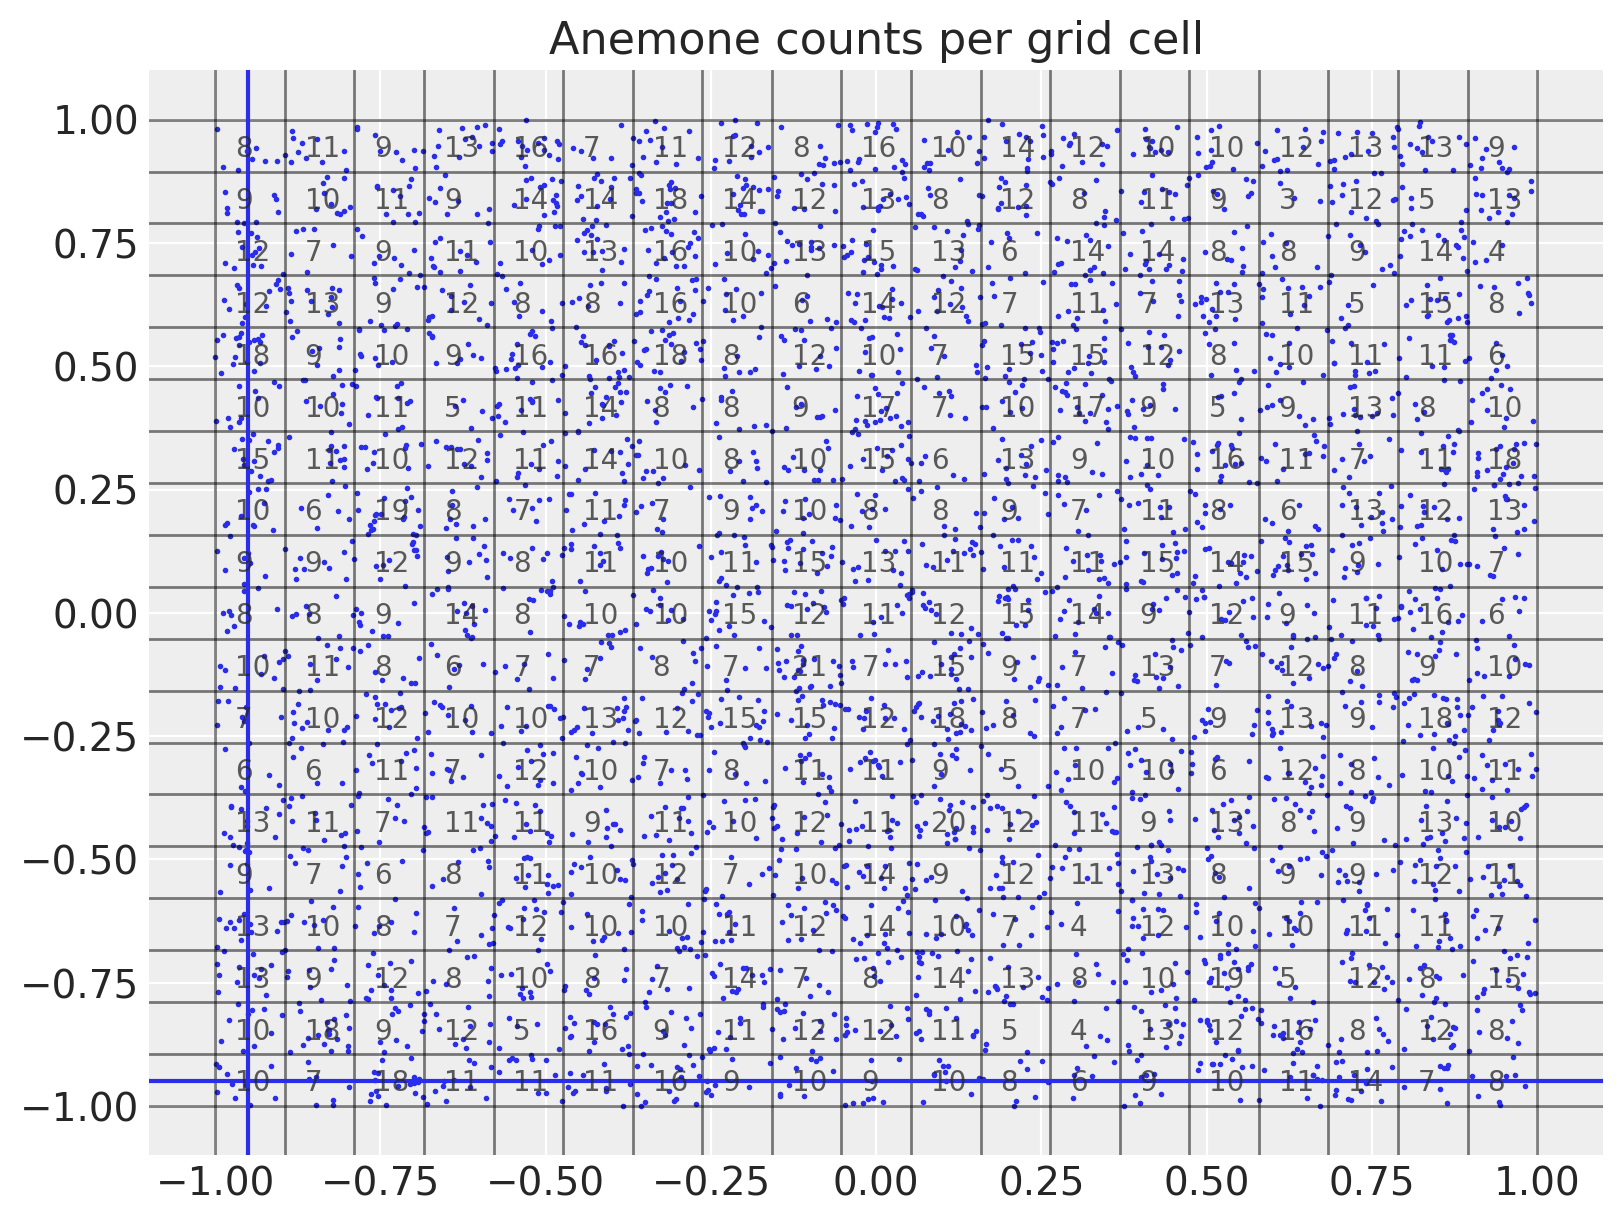

In [ ]:
line_kwargs = {"color": "k", "linewidth": 1, "alpha": 0.5}

plt.figure(figsize=(8, 6))
[plt.axhline(y, **line_kwargs) for y in quadrat_y]
[plt.axvline(x, **line_kwargs) for x in quadrat_x]
plt.scatter(xxRetained, yyRetained, s=1)

for i, row in enumerate(centroids):
    shifted_row = row - 0.02
    plt.annotate(cell_counts[i], shifted_row, alpha=0.75)

plt.title("Anemone counts per grid cell");
plt.axvline(-0.95)
plt.axhline(-0.95)

In [ ]:
# Build model
with pm.Model() as lgcp_model:
    mu = pm.Normal("mu", sigma=3)
    rho = pm.Uniform("rho", lower=0.3, upper=0.5)
    #rho = pm.Normal('rho', mu=0.15, sigma=0.5)
    variance = pm.InverseGamma("variance", alpha=1, beta=1)
    cov_func = variance * pm.gp.cov.Matern52(2, ls=rho)
    mean_func = pm.gp.mean.Constant(mu)

In [ ]:
with lgcp_model:
    # Create the GP object using MarginalSparse instead of Latent.

    # Approximation algorithm used is FITC.
    gp = pm.gp.MarginalSparse(cov_func=cov_func, mean_func = mean_func, approx='FITC') # Marginal sparse
    #gp = pm.gp.Latent(mean_func=mean_func, cov_func=cov_func) # Uncommend to use Latent. Comment above line.

    # initialize 10 inducing points with K-means
    # gp.util
    Xu = pm.gp.util.kmeans_inducing_points(10, centroids)
    
    # Noise to be passed as parameter to the marginal_likelihood method(version of .prior method for marginal
    # sparse implementation)
    σ = pm.HalfCauchy("σ", beta=5)
    
    # Place the prior over the function we want to model(the log intencity of the point process)
    # using the .marginal_likelihood method instead of the .prior method we used in the latent 
    # implementation. Parameters are the X training data, Xu inducing points, y observed data and noise sigma.
    log_intensity = gp.marginal_likelihood("log_intensity", X=centroids, Xu=Xu, y=cell_counts, noise=σ) # Sparse
    #log_intensity = gp.prior("log_intensity", X=centroids) # Uncommend to use Latent, comment above line.

    intensity = pm.math.exp(log_intensity)
    
    rates = intensity * area_per_cell
    # Poisson likelihood
    counts = pm.Poisson("counts", mu=rates, observed=cell_counts)

In [ ]:
with lgcp_model:
    trace = pm.sample(target_accept=0.95, chains=4, return_inferencedata=True)

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [σ, variance, rho, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 148 seconds.


In [ ]:
x_new = np.linspace(-1, 1, 40) # Create new entry points to apply the conditional and get prediction
y_new = np.linspace(-1, 1, 40)
xs, ys = np.asarray(np.meshgrid(x_new, y_new))
xy_new = np.asarray([xs.ravel(), ys.ravel()]).T

with lgcp_model:
    # Perform inference 
    # The conditional method creates the conditional, or predictive distribution 
    # over the latent function at arbitrary X* input points(xy_new here), f(x*).
    intensity_new = gp.conditional("log_intensity_new", Xnew=xy_new)

    spp_trace = pm.sample_posterior_predictive(
        trace, var_names=["log_intensity_new"], keep_size=True
    )
    # Extend trace to include spp_trace
    trace.extend(
        az.from_dict(posterior_predictive=spp_trace, dims={"log_intensity_new": ["sample"]})
      
    )
    # The predicted intensity values we get after applying conditioning stored in a var.
    intensity_samples = np.exp(trace.posterior_predictive["log_intensity_new"]) 

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(8, 5), constrained_layout=True)
axes = axes.ravel()

field_kwargs = {"marker": "o", "edgecolor": "None", "alpha": 0.5, "s": 20}

for i in range(6):
    # Plot 6 of the conditional samples
    field_handle = axes[i].scatter(
        xy_new[:, 0], xy_new[:, 1], c=intensity_samples.sel(chain=3, draw=i), **field_kwargs
    )

    obs_handle = axes[i].scatter(xxRetained, yyRetained, s=0.1, color="k",alpha=0.4)
    axes[i].axis("off")
    axes[i].set_title(f"Sample {i}")

plt.figlegend(
    (obs_handle, field_handle),
    ("Observed data", r"Posterior draws of $\lambda(s)$"),
    ncol=2,
    loc=(0.2, -0.01),
    fontsize=14,
    frameon=False,
);

Output hidden; open in https://colab.research.google.com to view.

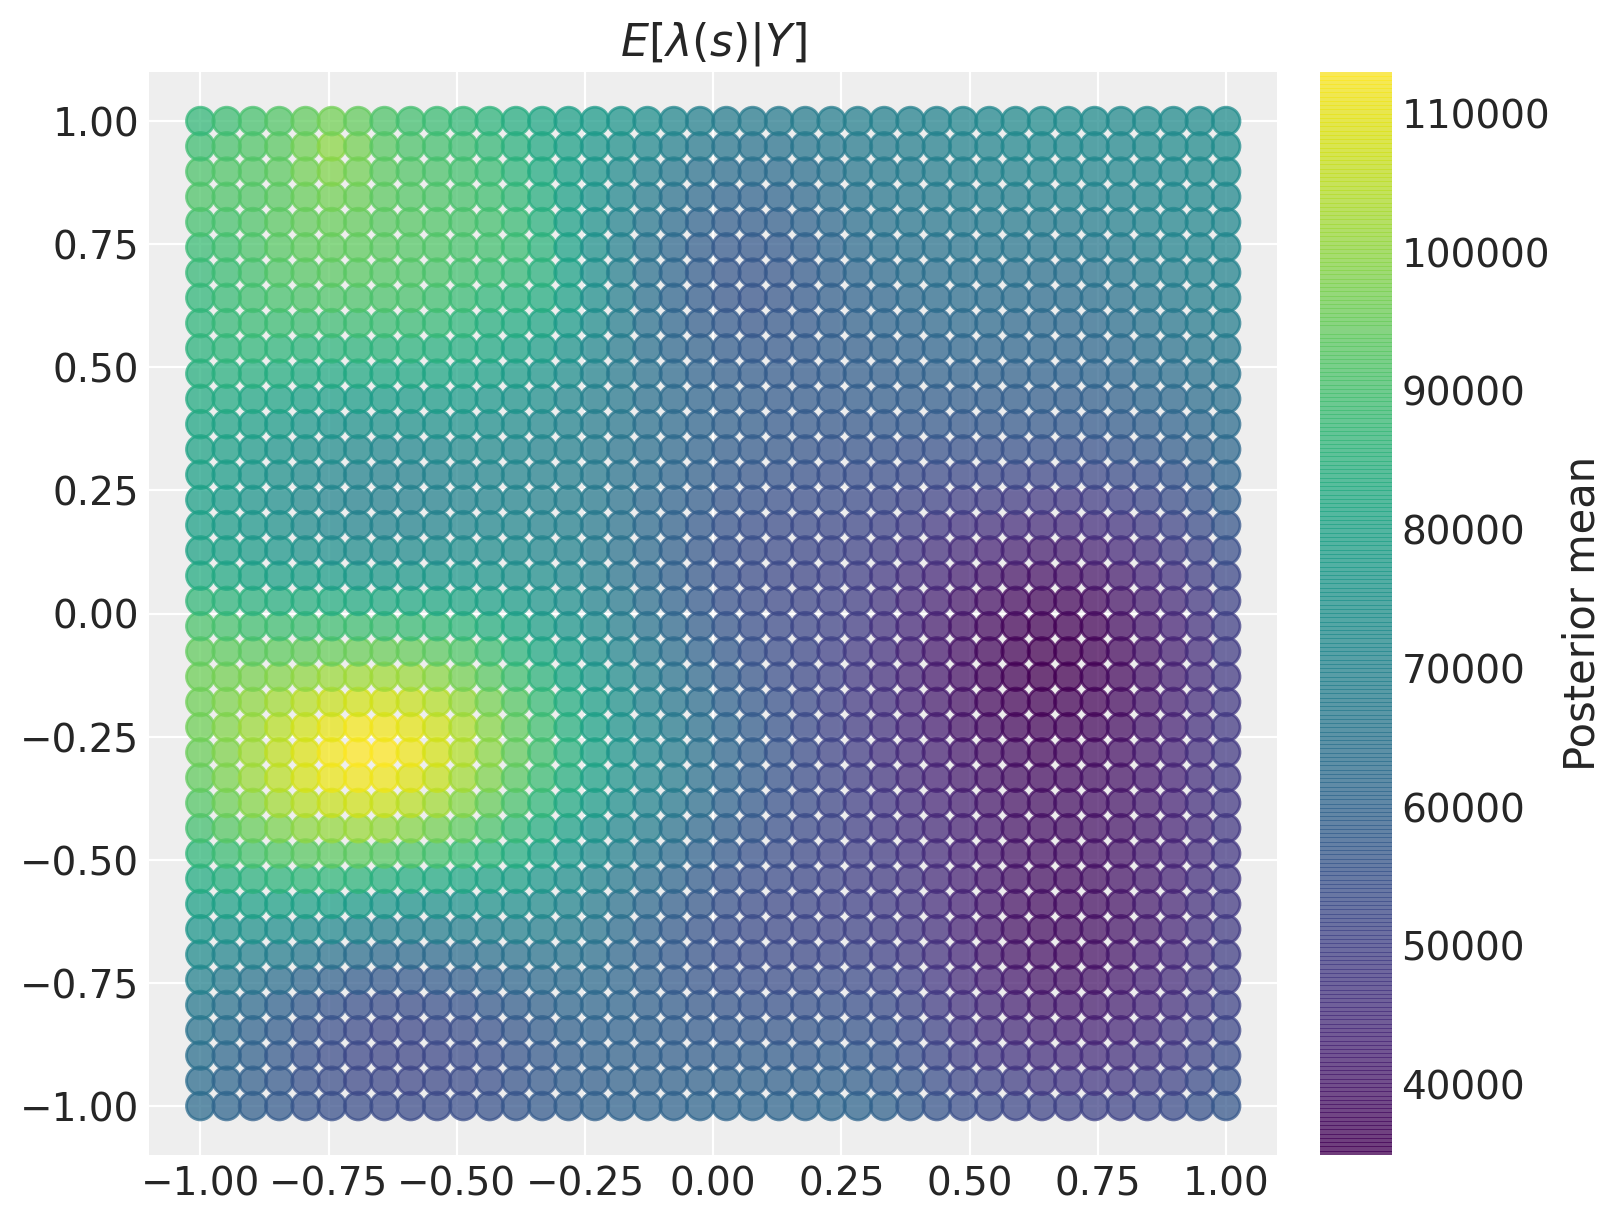

In [ ]:
fig = plt.figure(figsize=(8, 6))

plt.scatter(
    xy_new[:, 0],
    xy_new[:, 1],
    c=intensity_samples.mean(("chain", "draw")),
    marker="o",
    alpha=0.75,
    s=100,
    edgecolor=None,
)
#plt.scatter(xxRetained,yyRetained,s=15,marker='.', color="k")

plt.title("$E[\\lambda(s) \\vert Y]$")
plt.colorbar(label="Posterior mean");

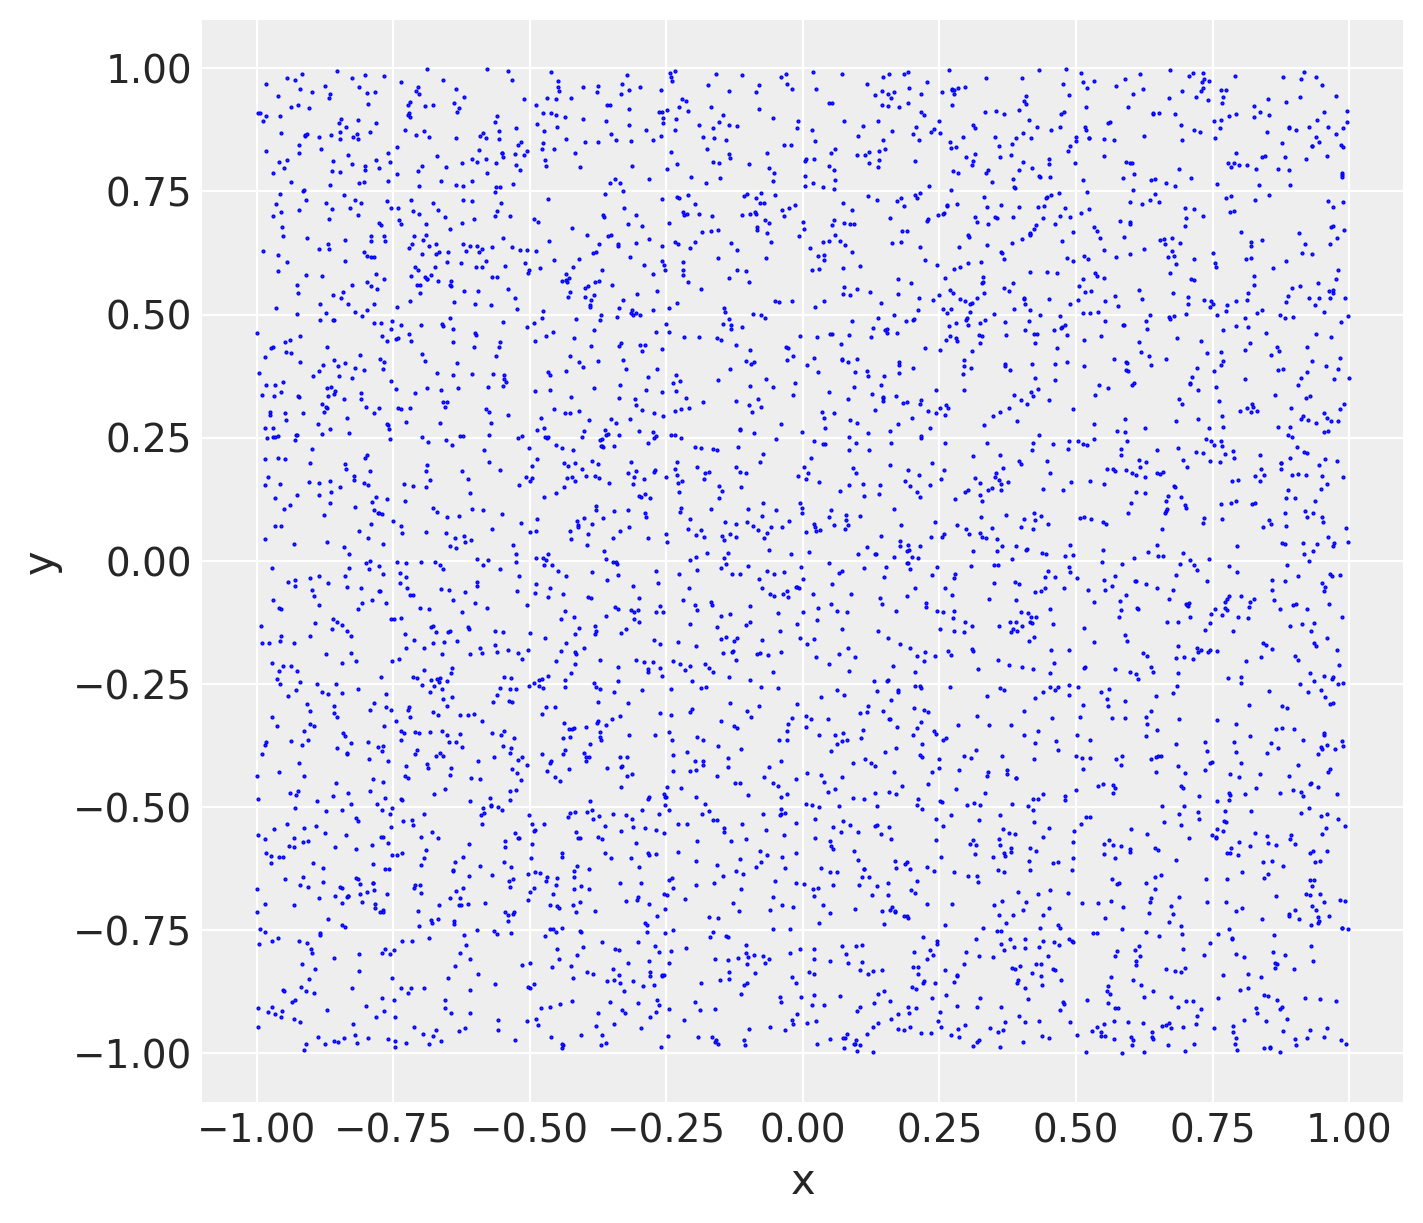

In [ ]:
fig = plt.figure(figsize=(7, 6))

plt.scatter(xxRetained,yyRetained, edgecolor='b', alpha=1, s=1, marker='.');
plt.xlabel("x"); plt.ylabel("y");
plt.show();